# Analysis of modes of transportation to work in the US
From the ACS Public Use Microdata Sample

In [482]:
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import Imputer
%matplotlib inline
seaborn.set_style(style='white')

Read in the data from the 2 csv files. File 'a' contains data from the first 25 states, and file b from the last 25 states. Each files is about 1.5 GB.

There are 283 columns of data, but we're only going to read in a subset of the columns. The data dictionary can be found at http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt .

After we read in each dataframe, we can concatenate them into a single dataframe.

In [483]:
use_cols = ['SERIALNO','PUMA','ST','ADJINC','PWGTP','AGEP','CIT',
            'COW','ENG','JWMNP','JWRIP','JWTR',
            'MAR','MIG','SCHL','SEX',
            'WAGP','WKHP','WKW','YOEP','DIS','ESR','FOD1P','HICOV', 
            'INDP','JWAP','JWDP','NATIVITY','NOP','OCCP','PERNP','PINCP',
            'RAC1P','SCIENGP','SCIENGRLP','SFR','WAOB']
PUMS_a = pd.read_csv('ss13pusa.csv', usecols = use_cols)
PUMS_b = pd.read_csv('ss13pusb.csv', usecols = use_cols)

In [484]:
PUMS_full = pd.concat([PUMS_a,PUMS_b])

In [485]:
PUMS_full.shape

(3132795, 37)

We now have a single dataframe with 37 columns and about 3 million rows. It's easier to work with pandas to clean data, but this data is already in a very useable format.

It'll be easier to work with the data if it's in a SQLite database. We can do this using the pandas function to_sql.

In [486]:
conn = sq.connect('PUMS.db')
PUMS_full.to_sql('PUMS',conn,index = False, if_exists = 'replace')

We can quickly check the table info for our new table using pragma table_info():

In [487]:
table_info = conn.execute('pragma table_info(PUMS);').fetchall()
for info in table_info: print(info)

(0, u'SERIALNO', u'INTEGER', 0, None, 0)
(1, u'PUMA', u'INTEGER', 0, None, 0)
(2, u'ST', u'INTEGER', 0, None, 0)
(3, u'ADJINC', u'INTEGER', 0, None, 0)
(4, u'PWGTP', u'INTEGER', 0, None, 0)
(5, u'AGEP', u'INTEGER', 0, None, 0)
(6, u'CIT', u'INTEGER', 0, None, 0)
(7, u'COW', u'REAL', 0, None, 0)
(8, u'ENG', u'REAL', 0, None, 0)
(9, u'JWMNP', u'REAL', 0, None, 0)
(10, u'JWRIP', u'REAL', 0, None, 0)
(11, u'JWTR', u'REAL', 0, None, 0)
(12, u'MAR', u'INTEGER', 0, None, 0)
(13, u'MIG', u'REAL', 0, None, 0)
(14, u'SCHL', u'REAL', 0, None, 0)
(15, u'SEX', u'INTEGER', 0, None, 0)
(16, u'WAGP', u'REAL', 0, None, 0)
(17, u'WKHP', u'REAL', 0, None, 0)
(18, u'WKW', u'REAL', 0, None, 0)
(19, u'YOEP', u'REAL', 0, None, 0)
(20, u'DIS', u'INTEGER', 0, None, 0)
(21, u'ESR', u'REAL', 0, None, 0)
(22, u'FOD1P', u'REAL', 0, None, 0)
(23, u'HICOV', u'INTEGER', 0, None, 0)
(24, u'INDP', u'REAL', 0, None, 0)
(25, u'JWAP', u'REAL', 0, None, 0)
(26, u'JWDP', u'REAL', 0, None, 0)
(27, u'NATIVITY', u'INTEGER', 0,

In [488]:
del PUMS_a, PUMS_b, PUMS_full

Now we're ready to start doing some analysis. Let's start by looking at the reported means of transportation to work. This information is in the column 'JWTR', and responses are grouped into 12 different codes. Let's return the code, the number of counts, and the sum of the weights grouped by code in descending order. 

In [489]:
query = ("SELECT JWTR, count(JWTR), sum(PWGTP) FROM PUMS GROUP BY JWTR ORDER BY count(JWTR) desc")
output = conn.execute(query).fetchall()

transit = np.asarray(output[:12])

transport_labels = ['None', 'Car, truck, or van', 'Bus or trolley bus',
                    'Strettcar','Subway or elevated','Railroad','Ferryboat', 
                    'Taxicab', 'Motorcycle', 'Bicycle','Walked',
                    'Worked at home','Other method']


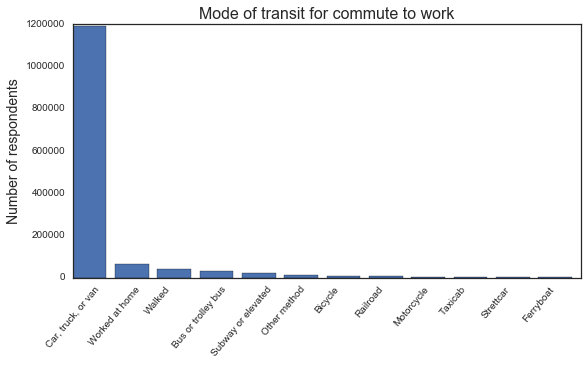

In [490]:
index = range(12)
label_order = [int(i) for i in transit[:,0]]
labels = [transport_labels[i] for i in label_order]
plt.figure(figsize = (8,5))
plt.bar(index, transit[:,1], 0.8)
plt.xticks(index, labels)
plt.xticks(rotation = 50)
plt.tight_layout()
plt.title('Mode of transit for commute to work', fontsize = 16)
plt.ylabel('Number of respondents', fontsize = 14)
plt.show()

We see that a huge majority of people commute to work by car, truck, or van. The other modes of transit are all so small in comparison that it's hard to read. Let's make a dataframe to display the numbers and percentages of the total. The survey also includes a column of weights to adjust for the fact that not all populations were equally sampled. We'll add a column to show the adjusted percentages based on these weights.

In [491]:
commute_transit = pd.DataFrame(data = transit, columns = ['Code','Total people','Adjusted total'])
commute_transit['Labels'] = labels
commute_transit['Percent'] = 100*commute_transit['Total people']/commute_transit['Total people'].sum()
commute_transit['Adjusted percent'] = 100*commute_transit['Adjusted total']/commute_transit['Adjusted total'].sum()
commute_transit = commute_transit[['Labels','Code','Total people','Percent','Adjusted percent']]
commute_transit

,Labels,Code,Total people,Percent,Adjusted percent
0,"Car, truck, or van",1,1188024,85.972633,85.822285
1,Worked at home,11,64891,4.695907,4.356349
2,Walked,10,41287,2.987778,2.791685
3,Bus or trolley bus,2,31486,2.278518,2.652806
4,Subway or elevated,4,22488,1.627368,1.850626
5,Other method,12,11600,0.839446,0.930944
6,Bicycle,9,8236,0.596007,0.613614
7,Railroad,5,8206,0.593836,0.571378
8,Motorcycle,8,3123,0.225999,0.201223
9,Taxicab,7,1273,0.092122,0.114635


Now, let's find out which states have the highest proportion of peolpe who bike or walk to work. we'll use the weighted values, and we'll only consider those who reported some mode of transit for their commute.

In [492]:
query = ("SELECT "
         "ST, "
         "sum(CASE WHEN JWTR == 9 THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (JWTR > 0 AND JWTR != 11) THEN PWGTP ELSE 0 END)"
         "FROM PUMS "
         "GROUP BY ST "
         "ORDER BY ST desc;")
        
bike_commuters = pd.DataFrame(data = conn.execute(query).fetchall(), 
                      columns=['State ID','Bike commuters','Total commuters'])
bike_commuters['Percent bike commuters'] = 100*bike_commuters['Bike commuters'].astype(float)/bike_commuters['Total commuters']
bike_commuters = bike_commuters.set_index('State ID')

In [493]:

bike_commuters.sort_values('Percent bike commuters', ascending = False).head(5)

,Bike commuters,Total commuters,Percent bike commuters
State ID,,,
11,15606,312154,4.999455
41,40979,1636766,2.503657
30,8088,436117,1.854548
15,9258,649484,1.425439
8,33427,2407446,1.388484


The state with by far the most bike commuters is Washinton D.C. (ID 11), with nearly 5%. Next, we see that Oregon (ID 41) has 2.5%, Montana (ID 30) has 1.9%, Hawaii (ID 15) has 1.4%, and Colorado (ID 8) has 1.4%.  

The PUMS data also contains total income for each person in the survey. Let's look at the range of incomes for different modes of commute transportation. Let's group modes of public transit together.

In [494]:
query = ("SELECT JWTR, PINCP FROM PUMS WHERE JWTR > 0 ORDER BY JWTR")
commute_income = pd.DataFrame(conn.execute(query).fetchall(), columns = ['Commute code','Income'])
public_transit_map = {1.0: 'Car', 2.0: 'Public transit', 3.0: 'Public transit', 4.0: 'Public transit',
                      5.0: 'Public transit', 6.0: 'Public transit', 7.0: 'Taxi', 8.0: 'Motorcycle',
                      9.0: 'Bike', 10.0:'Walk', 11.0: 'Work from home', 12.0:'Other'}
commute_income['Commute Type']=commute_income['Commute code'].map(public_transit_map)

In [495]:
grouped = commute_income.groupby('Commute Type')
commute_income2 = pd.DataFrame({col:vals['Income'] for col, vals in grouped})
meds = commute_income2.median().sort_values()
commute_income2 = commute_income2[meds.index]

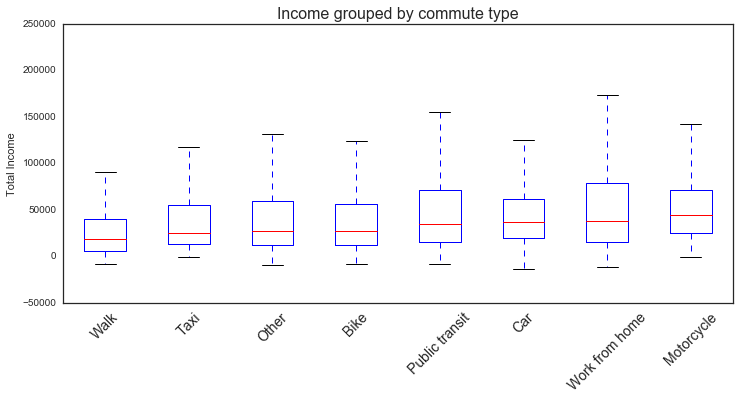

In [496]:
plt.figure(figsize=(12,5))
axes = commute_income2.boxplot(return_type = 'axes', grid = False, figsize = (12,5),
                               rot = 45, fontsize = 14)
plt.ylim((-50000,250000))
plt.title('Income grouped by commute type',fontsize = 16)
plt.ylabel('Total Income')
plt.show()

We see that the group with the lowest median total income are those who walk to work. The group with the highest median total income are those who ride a motorcycle to work. The group who work from home have the widest range of incomes, and the second highest median income.

We can also look at the breakdown by sex and by race. We'll focus on those who listed their race as white alone, black or African American alone, or asian alone.

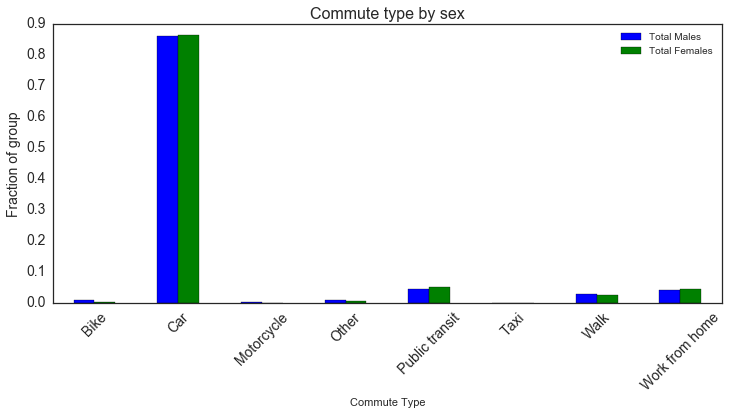

In [497]:
query = ("SELECT JWTR, "
         "sum(CASE WHEN (SEX == 1 AND RAC1P == 1) THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (SEX == 2 AND RAC1P == 1) THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (SEX == 1 AND RAC1P == 2) THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (SEX == 2 AND RAC1P == 2) THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (SEX == 1 AND RAC1P == 6) THEN PWGTP ELSE 0 END), "
         "sum(CASE WHEN (SEX == 2 AND RAC1P == 6) THEN PWGTP ELSE 0 END) "
         "FROM PUMS "
         "WHERE JWTR > 0 "
         "GROUP BY JWTR "
         "ORDER BY JWTR;")
commuter_race_sex = pd.DataFrame(conn.execute(query).fetchall(), columns = ['Commute code','White Males',
                                                                'White Females','Black Males','Black Females',
                                                                'Asian Males','Asian Females'])
commuter_race_sex['Total Males']=commuter_race_sex['White Males']+commuter_race_sex['Black Males']+commuter_race_sex['Asian Males']
commuter_race_sex['Total Females']=commuter_race_sex['White Females']+commuter_race_sex['Black Females']+commuter_race_sex['Asian Females']
commuter_race_sex_normalized = commuter_race_sex/commuter_race_sex.sum(axis=0)
commuter_race_sex_normalized['Commute code'] = commuter_race_sex['Commute code']
public_transit_map = {1.0: 'Car', 2.0: 'Public transit', 3.0: 'Public transit', 4.0: 'Public transit',
                      5.0: 'Public transit', 6.0: 'Public transit', 7.0: 'Taxi', 8.0: 'Motorcycle',
                      9.0: 'Bike', 10.0:'Walk', 11.0: 'Work from home', 12.0:'Other'}
commuter_race_sex_normalized['Commute Type']=commuter_race_sex['Commute code'].map(public_transit_map)
commuter_race_sex_normalized = commuter_race_sex_normalized.groupby('Commute Type').sum()
commuter_race_sex_normalized['Commute Type']=commuter_race_sex_normalized.index
commuter_race_sex_normalized.plot.bar(x = 'Commute Type', y = ['Total Males','Total Females'], 
                                      rot = 45, fontsize = 14, figsize=(12,5),grid=False)
plt.ylabel('Fraction of group',fontsize=14)
plt.title('Commute type by sex',fontsize=16)
plt.show()

It's really hard to see the values in the smallest columns. We can use a log scale to help us see the values for all of the categories.

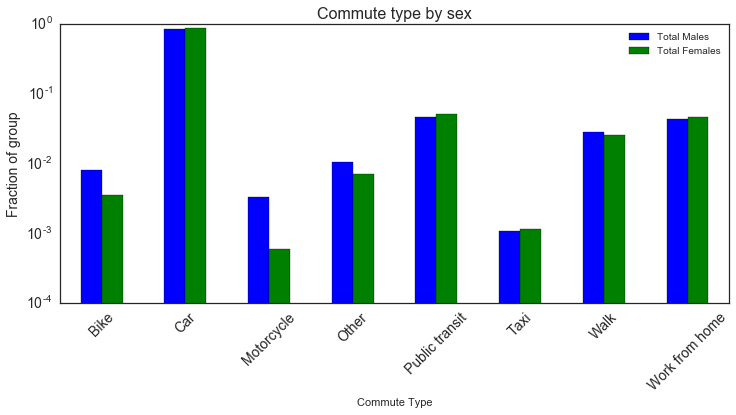

In [498]:
commuter_race_sex_normalized.plot.bar(x = 'Commute Type', y = ['Total Males','Total Females'],logy = True, 
                                      rot = 45, fontsize = 14, figsize=(12,5),grid=False)
plt.ylabel('Fraction of group',fontsize=14)
plt.title('Commute type by sex',fontsize=16)
plt.show()

We can see some interesting trends:  
    - More men than women commute by bicyle and by motorcycle  
    - In every other category, the numbers seem relatively equal  

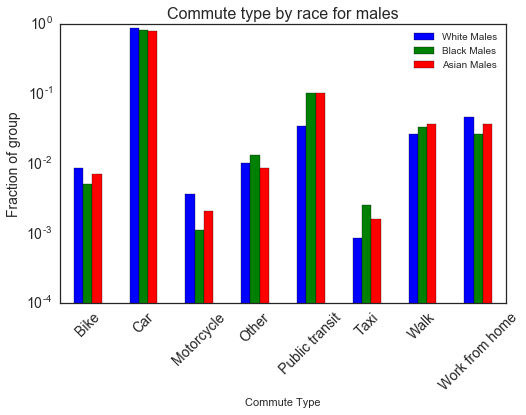

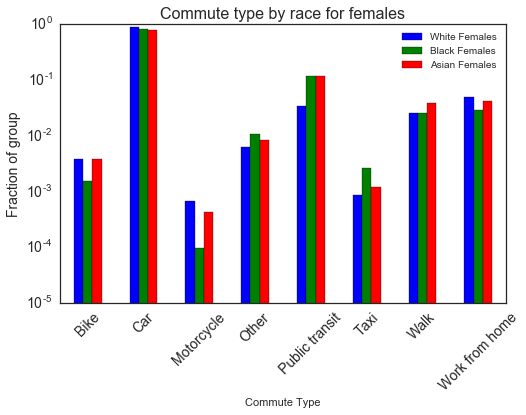

In [499]:
commuter_race_sex_normalized.plot.bar(x = 'Commute Type', y = ['White Males','Black Males','Asian Males'],logy = True, 
                                      rot = 45, fontsize = 14, figsize=(8,5),grid=False)
plt.ylabel('Fraction of group',fontsize=14)
plt.title('Commute type by race for males',fontsize=16)
plt.show()
commuter_race_sex_normalized.plot.bar(x = 'Commute Type', y = ['White Females','Black Females','Asian Females'],logy = True, 
                                      rot = 45, fontsize = 14, figsize=(8,5),grid=False)
plt.ylabel('Fraction of group',fontsize=14)
plt.title('Commute type by race for females',fontsize=16)
plt.show()

Looking at the breakdown by race (separated out by sex), we can pick up on some trends:  
- We see similar breakdowns by race for males and females  
- Compared to Whites and Asians, fewer Blacks bike or motorcycle to work, while more take taxis  
- More Blacks and Asians take public transit than Whites
- Asians are slightly more likely to walk


We can also explore the impact of age on mode of commute. In the next section, we'll see how the percent of people who bike, walk, and motrocycle to work varies with age.

In [500]:
def P_age(a, age_min, age_max):
    age = (age_min, age_max)
    out = conn.execute('SELECT sum(PWGTP) FROM PUMS WHERE JWTR>0 and AGEP>=? and AGEP<?;',age).fetchall()
    age_total = out[0][0]
    t = (a,age_min, age_max)
    out = conn.execute('SELECT sum(PWGTP) FROM PUMS WHERE JWTR == ? and AGEP>=? and AGEP<?;', t).fetchall()
    try:
        P = float(out[0][0])/age_total
    except:
        P = 0
    return P

In [501]:
age_steps = range(15,80,1)
bike_age = []
walk_age = []
motorcycle_age = []

for age in age_steps:
    bike_age.append(100*P_age(9,age,age+2))
    walk_age.append(100*P_age(10,age,age+2))
    motorcycle_age.append(100*P_age(8,age,age+2))

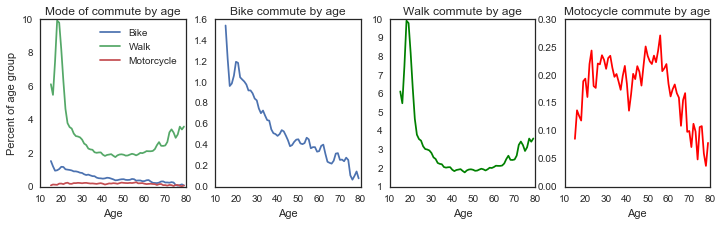

In [502]:
plt.figure(figsize = (12,3))

plt.subplot(1,4,1)
plt.plot(age_steps,bike_age)
plt.plot(age_steps,walk_age)
plt.plot(age_steps,motorcycle_age)
plt.legend(['Bike','Walk','Motorcycle'])
plt.xlabel('Age')
plt.ylabel('Percent of age group')
plt.title('Mode of commute by age')
plt.subplot(1,4,2)
plt.plot(age_steps,bike_age)
plt.xlabel('Age')
plt.title('Bike commute by age')
plt.subplot(1,4,3)
plt.plot(age_steps,walk_age, c='g')
plt.xlabel('Age')
plt.title('Walk commute by age')
plt.subplot(1,4,4)
plt.plot(age_steps,motorcycle_age, c='r')
plt.xlabel('Age')
plt.title('Motocycle commute by age')
plt.show()

We see a pretty clear relationship between age and percent who bike to work and walk to work. The percent of bike commuters decreases approximately linearly with age. The percent of commuters who walk to work shows a parabolic relationship, decreasing until about age 45-50 before increasing again. We see a spike in walk commuters around ~20-21, and a corresponding dip in bike commuters. I would want more data before interpreting this as a meaningful variation. The percent of motorcycle commuters is fairly even between ages 20-65, and steadily drops off after 65.  


Next, I want to try training a Random Forrest Classifier to predict how someone commutes to work. This dataset will be very challenging to classify, since such a huge majority of people take cars to work and our dataset may or may not include information that can predict commute mode. But let's give it a try! We'll limit our model to those who commute by car/truck/van, ferryboat, taxicab, motorcycle, bike, or walking.

In [558]:
query = ('SELECT ' 
         'JWTR, PUMA, ST, AGEP, CIT, COW, ENG, JWMNP, MAR, MIG, SCHL, SEX, '
         'WAGP, WKHP, DIS, HICOV, INDP, JWAP, JWDP, NATIVITY, '
         'PERNP, PINCP, RAC1P, SFR, WAOB '
         'FROM PUMS '
         'WHERE JWTR == 1 or JWTR == 6 or JWTR == 7 or JWTR == 8 or JWTR == 9 or JWTR == 10 ')
output = np.asarray(conn.execute(query).fetchall(), dtype = np.float)
Y_ = output[:,0]
X_ = output[:,1:]


We're going to have to figure out a method to deal with missing values. First, let's consider whether each variable in our list of features is numerical or categorical:  
- JWTR contains the labels, which are categorical
- PUMA is an area code, categorical
- ST is state, categorical
- AGEP is age, numerical
- CIT is citizenship, categorical
- COW is class of worker, categorical
- ENG is english speaking, categorical
- JWMNP is travel time to work, numerical
- MAR is marital status, categorical
- MIG is mobility status, categorical
- SCHL is educational attainment, categorical
- SEX is categorical
- WAGP is wages, numerical
- WKHP is hours worked per week, numerical
- DIS is disability, categorical
- HICOV is health coverage, categorical
- INDP is industry, categorical
- JWAP is time of arrival at work, numerical
- JWDP is time of departure for work, numerical
- NATIVITY is categorical
- PERNP is total earnings, numerical
- PINCP is total income, numerical
- RAC1P is primary race, categorical
- SFR is subfamily relationship, categorical
- WAOB is area of birth, categorical

We have two options: we can throw out any rows with missing data, or we can impute values for the missing data. We don't have that many samples in the non-car categories, so we want to keep as much data as we can. 

First, let's see how many NaN values are in each feature:


In [559]:
nans = np.isnan(X_)
num_nans = nans.sum(axis = 0)
num_nans

array([      0,       0,       0,       0,       0, 1025644,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0, 1217748,       0])

All of the NaN values occur in 2 columns: ENG and SFR. These are both categorical values, and so it makes sense to create a new category for "NaN". Let's set the NaN values in ENG and SFR to 0. 

In [560]:
X_new = np.nan_to_num(X_)
nans = np.isnan(X_new)
num_nans = nans.sum(axis = 0)
num_nans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [561]:
X = X_new
Y = Y_
#Standardize the data
X = (X-X.mean(axis = 0))/X.std(axis=0)
# now let's remove a sample as a test set
X_test = X[:30000,:]
X = X[30000:,:]
Y_test = Y[:30000]
Y = Y[30000:]

RF_model = RF(n_estimators = 100, n_jobs = -1, oob_score = True)
trained_RF = RF_model.fit(X,Y)
scores = trained_RF.score(X,Y)
scores_test = trained_RF.score(X_test,Y_test)
oob_scores = trained_RF.oob_score_
print('Training scores: %f' %scores)
print('Test scores: %f' %scores_test)
print('OOB scores: %f' %oob_scores)

Training scores: 0.999960
Test scores: 0.959733
OOB scores: 0.963232


In [589]:
predict_train = trained_RF.predict(X)
predict_test = trained_RF.predict(X_test)

labels = [1,6,7,8,9,10]
labels_str = ['Car','Ferry','Taxi','Motorcycle','Bike','Walk']
train_label_count = []
test_label_count = []
correct_train = []
correct_test = []
for l in labels:
    train_label_count.append(sum(Y==l))
    correct_train.append(sum(Y[(predict_train==Y)]==l))
    correct_test.append(sum(Y_test[(predict_test==Y_test)]==l))
    test_label_count.append(sum(Y_test==l))
    
label_count = pd.DataFrame({'Code':labels, 'Type':labels_str, 'Train count': train_label_count, 
                            'Train correct': correct_train, 'Test count': test_label_count,
                           'Test correct': correct_test})
label_count[['Code','Type','Train count','Train correct','Test count','Test correct']]

,Code,Type,Train count,Train correct,Test count,Test correct
0,1,Car,1159320,1159320,28704,28660
1,6,Ferry,574,572,3,0
2,7,Taxi,1246,1245,27,0
3,8,Motorcycle,3019,3015,104,0
4,9,Bike,8065,8051,171,16
5,10,Walk,40296,40269,991,116


Not a very useful classifier! It thinks that nearly everyone commutes to work in a car. It managed to get very high scores - but that's because over 95% of the test samples commuted by car. These results aren't surprising, given the data - nearly everyone does commute to work in a car, and it looks like our dataset doesn't have any features that are very strongly tied to other commute methods. While it did a pretty good job fitting the training data, this model is evidently over-trained and has minimal predictive value.

Let's take a look at feature importance:

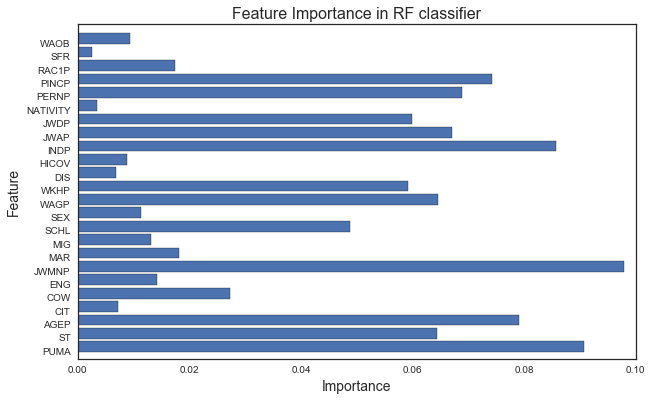

   Feature  Importance
6    JWMNP    0.097860
0     PUMA    0.090757
15    INDP    0.085719
2     AGEP    0.079063
20   PINCP    0.074210
19   PERNP    0.068796
16    JWAP    0.067127
11    WAGP    0.064461


In [590]:
feature_importance = trained_RF.feature_importances_
position = (np.arange(24)+0.5)
feature_labels = ('PUMA','ST','AGEP','CIT','COW','ENG','JWMNP',
                  'MAR','MIG','SCHL','SEX','WAGP','WKHP','DIS','HICOV',
                  'INDP','JWAP','JWDP','NATIVITY','PERNP','PINCP','RAC1P', 
                  'SFR','WAOB')
plt.figure(figsize = (10,6))
plt.barh(position, feature_importance)
plt.yticks(position,feature_labels)
plt.title('Feature Importance in RF classifier',fontsize=16)
plt.xlabel('Importance',fontsize=14)
plt.ylabel('Feature',fontsize=14)
plt.show()

importance = pd.DataFrame({'Feature':feature_labels, 
                           'Importance':feature_importance
                          }).sort_values('Importance',ascending=False)
print(importance.head(8))

The 8 most important features in the classifier were, in order of importance: travel time to work, area code, industry, age, total income, total earnings, time of arrival at work and wages. There are so many different code options for area code (PUMA) and occupation (INDP) that these could be used to over-train the model to the training data, reducing its predictive power. Let's see how our classifier does if we 1) exclude PUMA and INDP, and 2) include only the highest importance features (the remaining 6 from the list above).

Let's also look at JWMNP (travel time to work) and JWAP (time or arrival at work) to see if these might be contributing to over-fitting. If there are too many unique values, we could try binning them.

In [591]:
print(X_[:10,6])
print(X_[:10,16])
unique_JWMNP = len(np.unique(X_[:,6]))
unique_JWAP = len(np.unique(X_[:,16]))
print('Unique entries is %i in JWMNP and %i in JWAP.' %(unique_JWMNP, unique_JWAP))

[ 30.  15.  10.  45.   5.  10.  30.  25.  60.  45.]
[  96.  108.   72.   78.   72.   90.  120.  162.   72.   96.]
Unique entries is 138 in JWMNP and 48 in JWAP.


JWAP describes time of arrival at work to the nearest 5 minutes (each label corresponds to a time range equal to 5 minutes). Let's round each number to the nearest multiple of 6 to group by 30 minute blocks instead.

In [592]:
new_JWAP = X_[:,16]-X_[:,16]%6
X_mod_ = X_
X_mod_[:,16]=new_JWAP

In [593]:
include_features = [6,2,20,19,16,11]
X_mod = X_mod_[:,include_features]
#Standardize the data
X_mod = (X_mod-X_mod.mean(axis = 0))/X_mod.std(axis=0)
# now let's remove a sample as a test set
X_test_mod = X_mod[:30000,:]
X_mod = X_mod[30000:,:]


RF_model2 = RF(n_estimators = 100, n_jobs = -1, oob_score = True)
trained_RF2 = RF_model2.fit(X_mod,Y)
scores2 = trained_RF2.score(X_mod,Y)
scores_test2 = trained_RF2.score(X_test_mod,Y_test)
oob_scores2 = trained_RF2.oob_score_
print('Training scores: %f' %scores2)
print('Test scores: %f' %scores_test2)
print('OOB scores: %f' %oob_scores2)

Training scores: 0.988371
Test scores: 0.952200
OOB scores: 0.954280


In [594]:
predict_train2 = trained_RF2.predict(X_mod)
predict_test2 = trained_RF2.predict(X_test_mod)

labels = [1,6,7,8,9,10]
train_label_count2 = []
test_label_count2 = []
correct_train2 = []
correct_test2 = []
for l in labels:
    train_label_count2.append(sum(Y==l))
    correct_train2.append(sum(Y[(predict_train2==Y)]==l))
    correct_test2.append(sum(Y_test[(predict_test2==Y_test)]==l))
    test_label_count2.append(sum(Y_test==l))
    
label_count2 = pd.DataFrame({'Code':labels, 'Type':labels_str, 'Train count': train_label_count2, 
                            'Train correct': correct_train2, 'Test count': test_label_count2,
                           'Test correct': correct_test2})

label_count2[['Code','Type','Train count','Train correct','Test count','Test correct']]

,Code,Type,Train count,Train correct,Test count,Test correct
0,1,Car,1159320,1157998,28704,28441
1,6,Ferry,574,487,3,0
2,7,Taxi,1246,945,27,0
3,8,Motorcycle,3019,1967,104,0
4,9,Bike,8065,5468,171,8
5,10,Walk,40296,31555,991,117
